In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [43]:
from requirements import *
from utils.pp.preprocess import preprocess
from utils.pl.plot_embedding import plot_embedding
from utils.tl.transfer_labels import transfer_labels
from utils.pl.plot_ternary import plot_ternary

## Import AnnDatas

In [5]:
# Read in KG146 tumor data for mapping
filepath = f'{data_dir}/h5ads/KG146_Tumor_Mapping_Reference.h5ad'
ad_146 = sc.read_h5ad(filepath, backed=False)

In [6]:
# Read in KG146 organoid data
filepath = f'{data_dir}/h5ads/KG146_Organoids.h5ad'
ad_146_org = sc.read_h5ad(filepath, backed=False)

## Get genes to use as feature space for mapping

In [7]:
# Get DEGs per cell state
sc.tl.rank_genes_groups(
    ad_146,
    "cell_state",
    layer='log',
    use_raw=False,
    method='wilcoxon',
)

In [8]:
# Get features to use for cell state mapping
n_genes = 200
degs = ad_146.uns['rank_genes_groups']
cell_states = dict()
keys = list(degs['names'].dtype.fields.keys())
for key in keys:
    genes = degs['names'][key]
    mask = degs['logfoldchanges'][key] > 3
    mask &= degs['pvals_adj'][key] < 0.001
    mask &= pd.Index(genes).isin(ad_146_org.var.index)
    cell_states[key] = genes[mask][:n_genes].tolist()
label_features = [v for vals in cell_states.values() for v in vals]

## Perform label transfer on each organoid and condition

In [9]:
# Columns to retain after co-embedding
keep_cols = [
    'Sample ID',
    'label_group',
    'cell_state',
    'organoid',
    'condition',
]

In [33]:
from tqdm import tqdm

# Reference and unlabeled group
ad_146.obs['label_group'] = 'reference'
ad_146_org.obs['label_group'] = 'unlabeled'
labeled_ad = dict()

# Label transfer is performed separately for each sample
for name, group in tqdm(ad_146_org.obs.groupby(['organoid', 'condition'])):

    # Coembed each sample with tumor AnnData (labeled reference)
    ad_cmb = anndata.concat(
        adatas=[ad_146, ad_146_org[group.index]],
        join="outer",
        label="label_group",
        keys=["reference", "unlabeled"],
        index_unique=None,
    )
    ad_cmb.obsm.clear()
    ad_cmb.obs = ad_cmb.obs[keep_cols]

    # Re-process data after co-embedding
    kwargs = dict(
        hvgs=label_features, show_progress=False,
        cluster=False, neighbors=False, umap=False, impute=False,
    )
    ad_cmb = preprocess(ad_cmb, **kwargs)

    # Transfer labels from tumor to organoid
    transfer_labels(ad_cmb, label_column='cell_state', knn=30, mnn=60)
    labeled_ad[name] = ad_cmb

100%|██████████| 6/6 [01:25<00:00, 14.20s/it]


In [39]:
# Transfer organoid labels back to original AnnData
columns = [f'P({state})' for state in cell_states.keys()]  # probabilities
columns += ['cell_state']  # label

for ad in labeled_ad.values():
    ixn = ad_146_org.obs.index.intersection(ad.obs.index)
    ad_146_org.obs.loc[ixn, columns] = ad.obs[columns]

In [51]:
# Aggregate probabilities over 3 axes/groups of cell states
label_map = {
    'ISC/TA-like': ["Proliferative", "ISC"],
    'Diff. Intestine-like': ["Absorptive", "Secretory"],
    'Non-Canonical': ["Injury Repair", "Neuroendocrine", "Fetal", "Squamous"],
}
for key, vals in label_map.items():
    prob = ad_146_org.obs[[f"P({v})" for v in vals]].sum(axis=1)
    ad_146_org.obs[f"P({key})"] = prob

## Visualize results as ternary plots

In [59]:
from matplotlib.colors import LinearSegmentedColormap as lsc
conditions = [
    ('OKG146P', 'HISC'),
    ('OKG146Li', 'HISC'),
    ('OKG146P', 'IGFF'),
    ('OKG146Li', 'IGFF'),
]
primary_cmap = lsc.from_list( "", [(0., 'w'), (1, '#EBA131')], N=256)
met_cmap = lsc.from_list( "", [(0., 'w'), (1, '#625793')], N=256)
cmaps = [
    primary_cmap,
    met_cmap,
    primary_cmap,
    met_cmap,
]

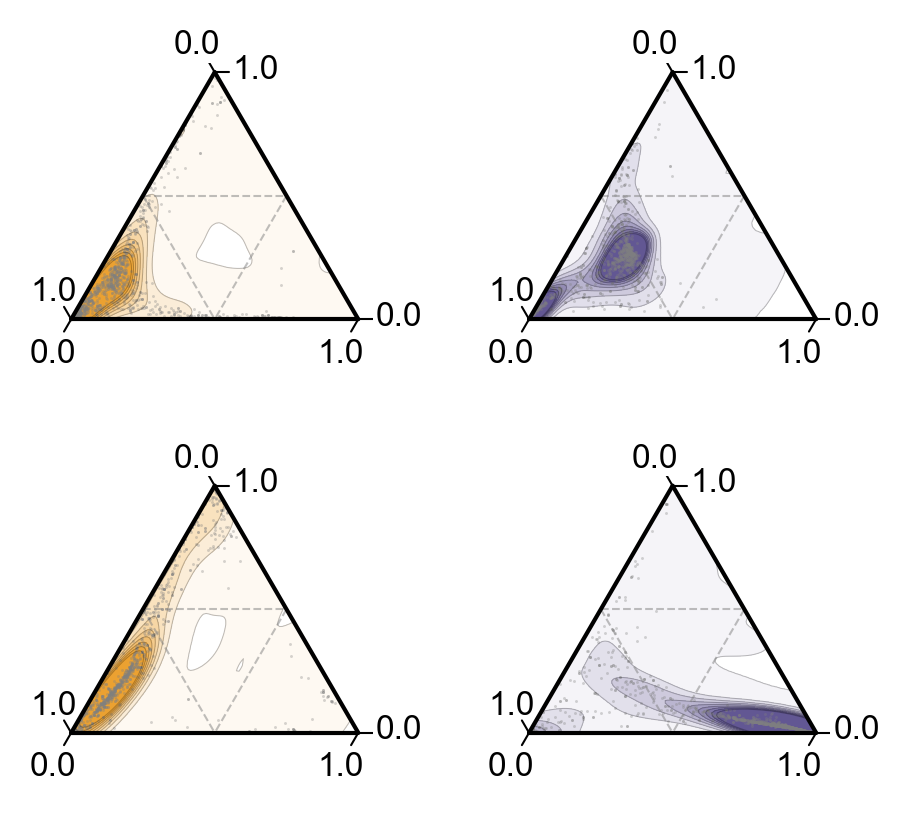

In [60]:
# Scatter Plot
fig, axes = plt.subplots(
    2, 2,
    figsize=(2.2*1.5125, 2*1.5125), 
    gridspec_kw={'hspace':0.45, 'wspace':0.45}
)

states = ['Non-Canonical', 'Diff. Intestine-like', 'ISC/TA-like']
ternary_axes = [f"P({state})" for state in states]

groupby = ad_146_org.obs.groupby(['organoid', 'condition'])

for i, (condition, cmap) in enumerate(zip(conditions, cmaps)):
    group = groupby.get_group(condition)
    points = group[ternary_axes].values
    plot_ternary(points, cmap, states, axes.flat[i])